<a href="https://colab.research.google.com/github/mashaan14/YouTube-channel/blob/main/notebooks/2024_01_08_CNN_and_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification using CNN and Vision Transformers (ViT)
I borrowed some code from these resources:
  - [PyTorch Tutorials: Training a Classifier](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)
  - [PyTorch Lightning Tutorials: Vision Transformers](https://lightning.ai/docs/pytorch/stable/notebooks/course_UvA-DL/11-vision-transformer.html)

## References:
```bibtex
@ARTICLE{726791,
  author  = {Lecun, Y. and Bottou, L. and Bengio, Y. and Haffner, P.},
  journal	= {Proceedings of the IEEE},
  title	  = {Gradient-based learning applied to document recognition},
  year	  = {1998},
  volume  = {86},
  number	= {11},
  pages		= {2278-2324},
  doi			= {10.1109/5.726791}}
```
```bibtex
@misc{dosovitskiy2021image,
  title         = {An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale},
  author        = {Alexey Dosovitskiy and Lucas Beyer and Alexander Kolesnikov and Dirk Weissenborn and Xiaohua Zhai and Thomas Unterthiner and Mostafa Dehghani and Matthias Minderer and Georg Heigold and Sylvain Gelly and Jakob Uszkoreit and Neil Houlsby},
  year          ={2021},
  eprint        = {2010.11929},
  archivePrefix = {arXiv},
  primaryClass  = {cs.CV}
}
```

## Prepare libraries and data

In [ ]:
# Standard libraries
import os
import random
import numpy as np
from datetime import datetime

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

# torchvision
import torchvision
import torchvision.transforms as transforms

# tqdm
from tqdm.notebook import tqdm_notebook

In [ ]:
# Setting the seed
random.seed(42)
g = torch.Generator().manual_seed(2147483647) # for reproducibility

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

Device: cuda:0


In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# set the preprocess operations to be performed on train/val/test samples
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# download CIFAR10 training set and reserve 50000 for training
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_set, val_set = torch.utils.data.random_split(train_dataset, [40000, 10000])

# download CIFAR10 test set
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# We define the data loaders using the datasets
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=32, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(dataset=val_set, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=32, shuffle=False)

100%|██████████| 170498071/170498071 [00:03<00:00, 48082384.18it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# print the dimension of images to verify all loaders have the same dimensions
def print_dim(loader, text):
  print('---------'+text+'---------')
  print(len(loader.dataset))
  for image, label in loader:
    print(image.shape)
    print(label.shape)
    break

print_dim(train_loader,'training loader')
print_dim(val_loader,'validation loader')
print_dim(test_loader,'test loader')

---------training loader---------
40000
torch.Size([32, 3, 32, 32])
torch.Size([32])
---------validation loader---------
10000
torch.Size([32, 3, 32, 32])
torch.Size([32])
---------test loader---------
10000
torch.Size([32, 3, 32, 32])
torch.Size([32])


## Visualize some examples

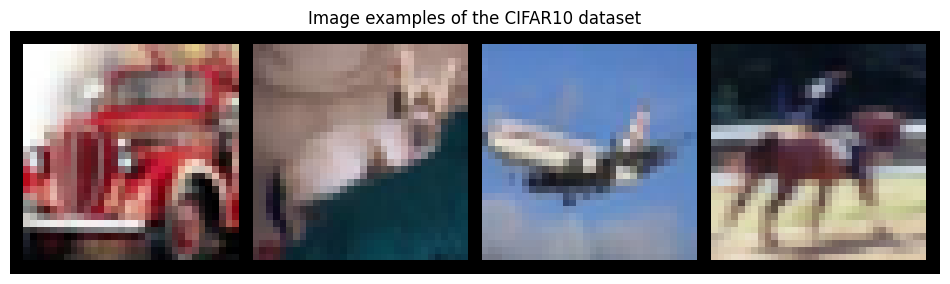

truck cat   plane horse


In [ ]:
# get some random validation images
num_images = 4
dataiter = iter(val_loader)
CIFAR10_examples_images, CIFAR10_examples_labels = next(dataiter)
CIFAR10_examples_images = CIFAR10_examples_images[:num_images,:,:,:]
CIFAR10_examples_labels = CIFAR10_examples_labels[:num_images]

# show images
npimg = torchvision.utils.make_grid(CIFAR10_examples_images, normalize=True).numpy()
plt.figure(figsize=(12, 6))
plt.title("Image examples of the CIFAR10 dataset")
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.axis("off")
plt.show()
# print labels
print(' '.join(f'{classes[CIFAR10_examples_labels[j]]:5s}' for j in range(CIFAR10_examples_labels.shape[0])))

## CNN

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
model_CNN = CNN()

# Transfer to GPU
model_CNN.to(device)

# setup the loss function
criterion = nn.CrossEntropyLoss()
# setup the optimizer with the learning rate
model_CNN_optimizer = optim.Adam(model_CNN.parameters(), lr=3e-4)

In [ ]:
model_CNN

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

## How data flows inside a CNN?

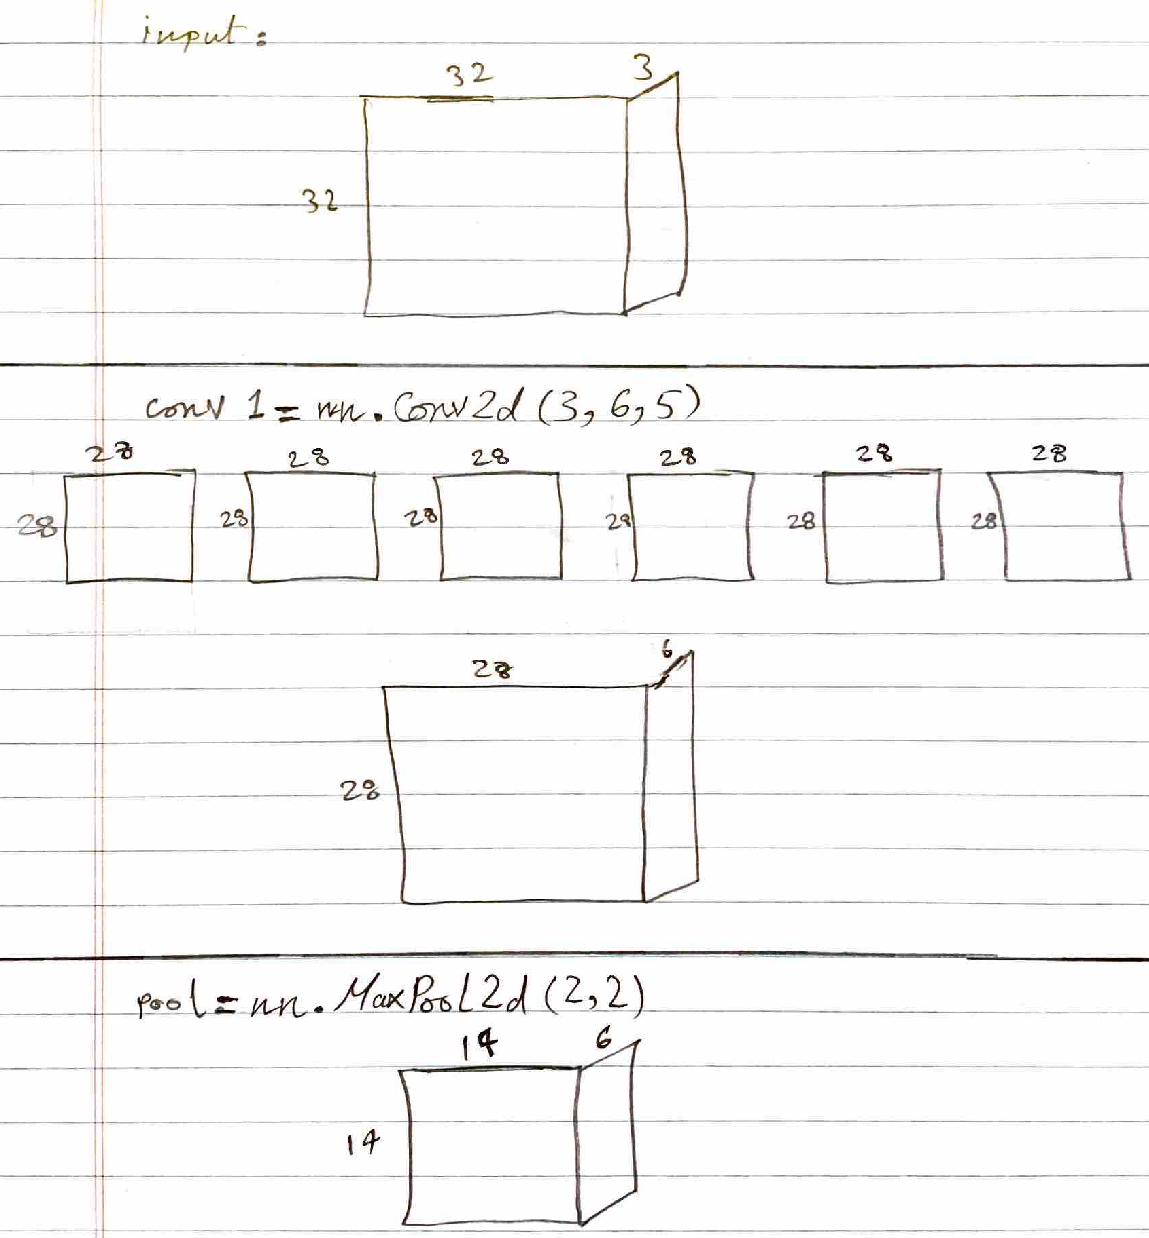

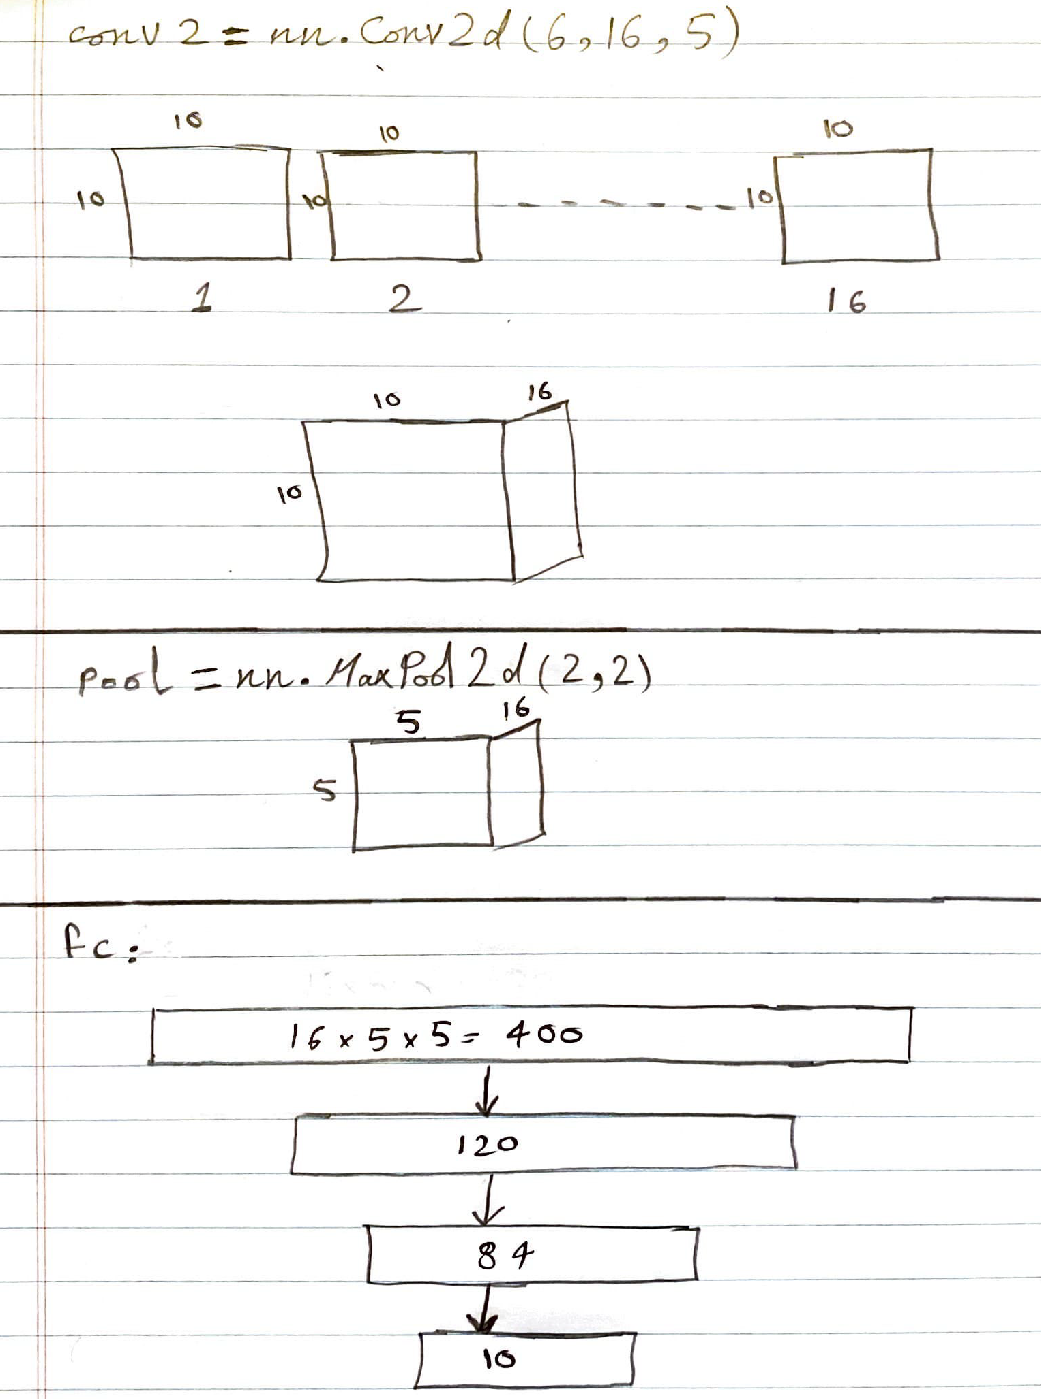

## CNN Training

### Training loop

In [ ]:
# set an empty list to plot the loss later
loss_train_list = []
loss_val_list = []
loss_train_avg = 0
loss_val_avg = 0

start.record()

# Training loop
for epoch in range(20):
  for imgs, labels in tqdm_notebook(train_loader, desc='epoch '+str(epoch)):
    # Make sure gradient tracking is on, and do a pass over the data
    model_CNN.train(True)
    # Transfer to GPU
    imgs, labels = imgs.to(device), labels.to(device)
    # zero the parameter gradients
    model_CNN_optimizer.zero_grad()
    # Make predictions for this batch
    preds = model_CNN(imgs)
    # Compute the loss and its gradients
    loss = criterion(preds, labels)
    # append this loss to the list for later plotting
    loss_train_avg += loss
    # backpropagate the loss
    loss.backward()
    # adjust parameters based on the calculated gradients
    model_CNN_optimizer.step()


  # Set the model to evaluation mode, disabling dropout and using population
  model_CNN.eval()
  # Disable gradient computation and reduce memory consumption.
  with torch.inference_mode():
      for i, vdata in enumerate(val_loader):
          vinputs, vlabels = vdata
          vinputs, vlabels = vinputs.to(device), vlabels.to(device)
          voutputs = model_CNN(vinputs)
          vloss = criterion(voutputs, vlabels)
          loss_val_avg += vloss

  loss_train_avg = loss_train_avg/len(train_loader.dataset)
  loss_train_list.append(loss_train_avg.item())
  loss_val_avg = loss_val_avg/len(val_loader.dataset)
  loss_val_list.append(loss_val_avg.item())

  print(f'Epoch {epoch:03d} | train loss: {loss_train_avg:.4f} | validation loss: {loss_val_avg:.4f}')

end.record()
torch.cuda.synchronize()
time_CNN = start.elapsed_time(end)  # milliseconds

epoch 0:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 000 | train loss: 0.0563 | validation loss: 0.0496


epoch 1:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 001 | train loss: 0.0482 | validation loss: 0.0471


epoch 2:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 002 | train loss: 0.0453 | validation loss: 0.0442


epoch 3:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 003 | train loss: 0.0428 | validation loss: 0.0432


epoch 4:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 004 | train loss: 0.0407 | validation loss: 0.0404


epoch 5:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 005 | train loss: 0.0390 | validation loss: 0.0399


epoch 6:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 006 | train loss: 0.0377 | validation loss: 0.0388


epoch 7:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 007 | train loss: 0.0364 | validation loss: 0.0377


epoch 8:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 008 | train loss: 0.0353 | validation loss: 0.0369


epoch 9:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 009 | train loss: 0.0342 | validation loss: 0.0377


epoch 10:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 010 | train loss: 0.0333 | validation loss: 0.0359


epoch 11:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 011 | train loss: 0.0325 | validation loss: 0.0356


epoch 12:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 012 | train loss: 0.0316 | validation loss: 0.0351


epoch 13:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 013 | train loss: 0.0308 | validation loss: 0.0347


epoch 14:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 014 | train loss: 0.0301 | validation loss: 0.0348


epoch 15:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 015 | train loss: 0.0295 | validation loss: 0.0352


epoch 16:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 016 | train loss: 0.0288 | validation loss: 0.0349


epoch 17:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 017 | train loss: 0.0281 | validation loss: 0.0349


epoch 18:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 018 | train loss: 0.0275 | validation loss: 0.0348


epoch 19:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 019 | train loss: 0.0268 | validation loss: 0.0347


### Plot training and validation losses

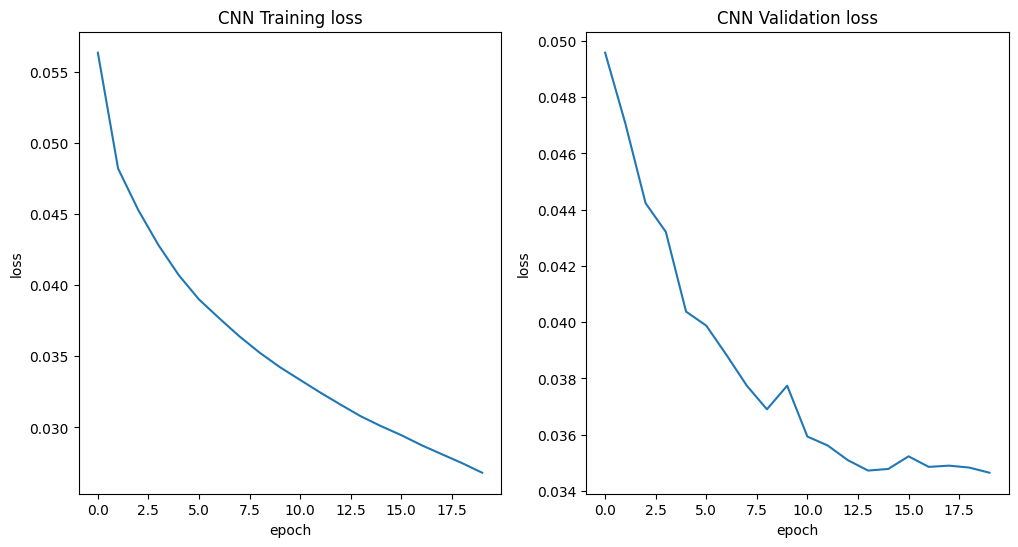

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.plot(loss_train_list)
ax1.set_title('CNN Training loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')

ax2.plot(loss_val_list)
ax2.set_title('CNN Validation loss')
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')
plt.show()

## CNN Testing

In [ ]:
# Set the model to inference mode, disabling dropout.
model_CNN.eval()
# evaluate network
acc_total = 0
with torch.inference_mode():
  for imgs, labels in tqdm_notebook(test_loader):

    imgs, labels = imgs.to(device), labels.to(device)
    preds = model_CNN(imgs)
    pred_cls = preds.data.max(1)[1]
    acc_total += pred_cls.eq(labels.data).cpu().sum()

acc_CNN = acc_total.item()/len(test_loader.dataset)
print(f'Accuracy on test set = {acc_CNN*100:.2f}%')


  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on test set = 61.86%


## ViT utilities

### ViT parameters

In [ ]:
image_size = 32
embed_dim=256
hidden_dim=embed_dim*3
num_heads=8
num_layers=6
patch_size=8
num_patches=16
num_channels=3
num_classes=10
dropout=0.2

### Split an image into patches

In [ ]:
def img_to_patch(x, patch_size, flatten_channels=True):
    """
    Inputs:
        x - Tensor representing the image of shape [B, C, H, W]
        patch_size - Number of pixels per dimension of the patches (integer)
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
    B, C, H, W = x.shape # [B, C, H, W], CIFAR10 [B, 3, 32, 32]
    x = x.reshape(B, C, H // patch_size, patch_size, W // patch_size, patch_size) # [B, C, H', p_H, W', p_W], CIFAR10 [B, 3, 4, 8, 4, 8]
    x = x.permute(0, 2, 4, 1, 3, 5)  # [B, H', W', C, p_H, p_W], CIFAR10 [B, 4, 4, 1, 8, 8]
    x = x.flatten(1, 2)  # [B, H'*W', C, p_H, p_W], CIFAR10 [B, 16, 3, 8, 8]
    if flatten_channels:
        x = x.flatten(2, 4)  # [B, H'*W', C*p_H*p_W], CIFAR10 [B, 16, 192]
    return x

### Visualize the image patches

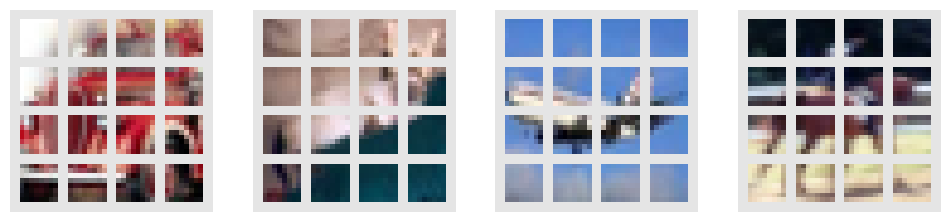

In [ ]:
img_patches = img_to_patch(CIFAR10_examples_images, patch_size=patch_size, flatten_channels=False)

fig, ax = plt.subplots(1,CIFAR10_examples_images.shape[0], figsize=(12, 6))
for i in range(CIFAR10_examples_images.shape[0]):
    img_grid = torchvision.utils.make_grid(img_patches[i], nrow=int(image_size/patch_size), normalize=True, pad_value=0.9)
    img_grid = img_grid.permute(1, 2, 0)
    ax[i].imshow(img_grid)
    ax[i].axis("off")
plt.show()
plt.close()

## ViT

In [ ]:
class AttentionBlock(nn.Module):
    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
        """
        Inputs:
            embed_dim - Dimensionality of input and attention feature vectors
            hidden_dim - Dimensionality of hidden layer in feed-forward network
                         (usually 2-4x larger than embed_dim)
            num_heads - Number of heads to use in the Multi-Head Attention block
            dropout - Amount of dropout to apply in the feed-forward network
        """
        super().__init__()

        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        self.linear = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        inp_x = self.layer_norm_1(x)
        x = x + self.attn(inp_x, inp_x, inp_x)[0]
        x = x + self.linear(self.layer_norm_2(x))
        return x

In [ ]:
class VisionTransformer(nn.Module):
    def __init__(
        self,
        embed_dim,
        hidden_dim,
        num_channels,
        num_heads,
        num_layers,
        num_classes,
        patch_size,
        num_patches,
        dropout=0.0,
    ):
        """
        Inputs:
            embed_dim - Dimensionality of the input feature vectors to the Transformer
            hidden_dim - Dimensionality of the hidden layer in the feed-forward networks
                         within the Transformer
            num_channels - Number of channels of the input (3 for RGB or 1 for grayscale)
            num_heads - Number of heads to use in the Multi-Head Attention block
            num_layers - Number of layers to use in the Transformer
            num_classes - Number of classes to predict
            patch_size - Number of pixels that the patches have per dimension
            num_patches - Maximum number of patches an image can have
            dropout - Amount of dropout to apply in the feed-forward network and
                      on the input encoding
        """
        super().__init__()

        self.patch_size = patch_size

        # Layers/Networks
        self.input_layer = nn.Linear(num_channels * (patch_size**2), embed_dim)
        self.transformer = nn.Sequential(
            *(AttentionBlock(embed_dim, hidden_dim, num_heads, dropout=dropout) for _ in range(num_layers))
        )
        self.mlp_head = nn.Sequential(nn.LayerNorm(embed_dim), nn.Linear(embed_dim, num_classes))
        self.dropout = nn.Dropout(dropout)

        # Parameters/Embeddings
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1, 1 + num_patches, embed_dim))

    def forward(self, x):
        # Preprocess input
        x = img_to_patch(x, self.patch_size)        # x.shape ---> batch, num_patches, (patch_channels*patch_width*patch_height)
        B, T, _ = x.shape
        x = self.input_layer(x)                     # x.shape ---> batch, num_patches, embed_dim

        # Add CLS token and positional encoding
        cls_token = self.cls_token.repeat(B, 1, 1)
        x = torch.cat([cls_token, x], dim=1)        # x.shape ---> batch, num_patches+1, embed_dim
        x = x + self.pos_embedding[:, : T + 1]      # x.shape ---> batch, num_patches+1, embed_dim

        # Apply Transformer
        x = self.dropout(x)
        x = x.transpose(0, 1)                       # x.shape ---> num_patches+1, batch, embed_dim
        x = self.transformer(x)                     # x.shape ---> num_patches+1, batch, embed_dim

        # Perform classification prediction
        cls = x[0]
        out = self.mlp_head(cls)
        return out

In [ ]:
model_ViT = VisionTransformer(embed_dim=embed_dim,
                          hidden_dim=hidden_dim,
                          num_heads=num_heads,
                          num_layers=num_layers,
                          patch_size=patch_size,
                          num_channels=num_channels,
                          num_patches=num_patches,
                          num_classes=num_classes,
                          dropout=dropout)

# Transfer to GPU
model_ViT.to(device)

# setup the loss function
criterion = nn.CrossEntropyLoss()
# setup the optimizer with the learning rate
model_ViT_optimizer = optim.Adam(model_ViT.parameters(), lr=3e-4)

In [ ]:
model_ViT

VisionTransformer(
  (input_layer): Linear(in_features=192, out_features=256, bias=True)
  (transformer): Sequential(
    (0): AttentionBlock(
      (layer_norm_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (layer_norm_2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (linear): Sequential(
        (0): Linear(in_features=256, out_features=768, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.2, inplace=False)
        (3): Linear(in_features=768, out_features=256, bias=True)
        (4): Dropout(p=0.2, inplace=False)
      )
    )
    (1): AttentionBlock(
      (layer_norm_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (layer_norm_2): Laye

## How data flows inside a ViT?

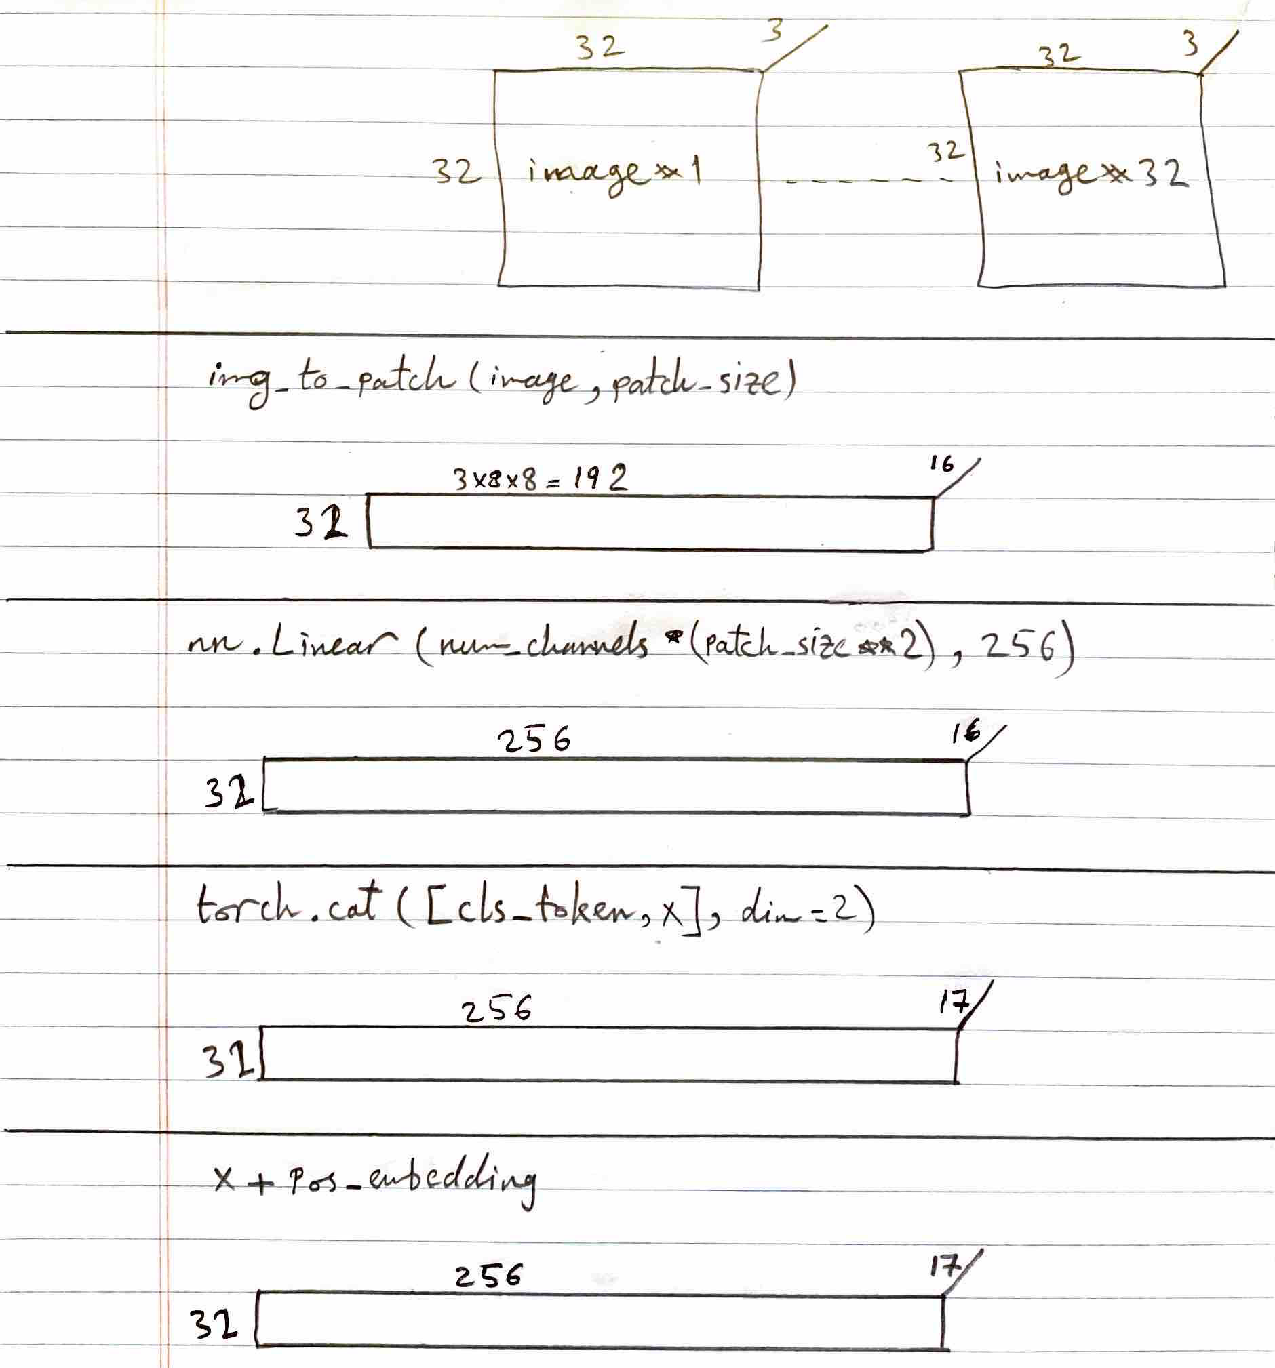

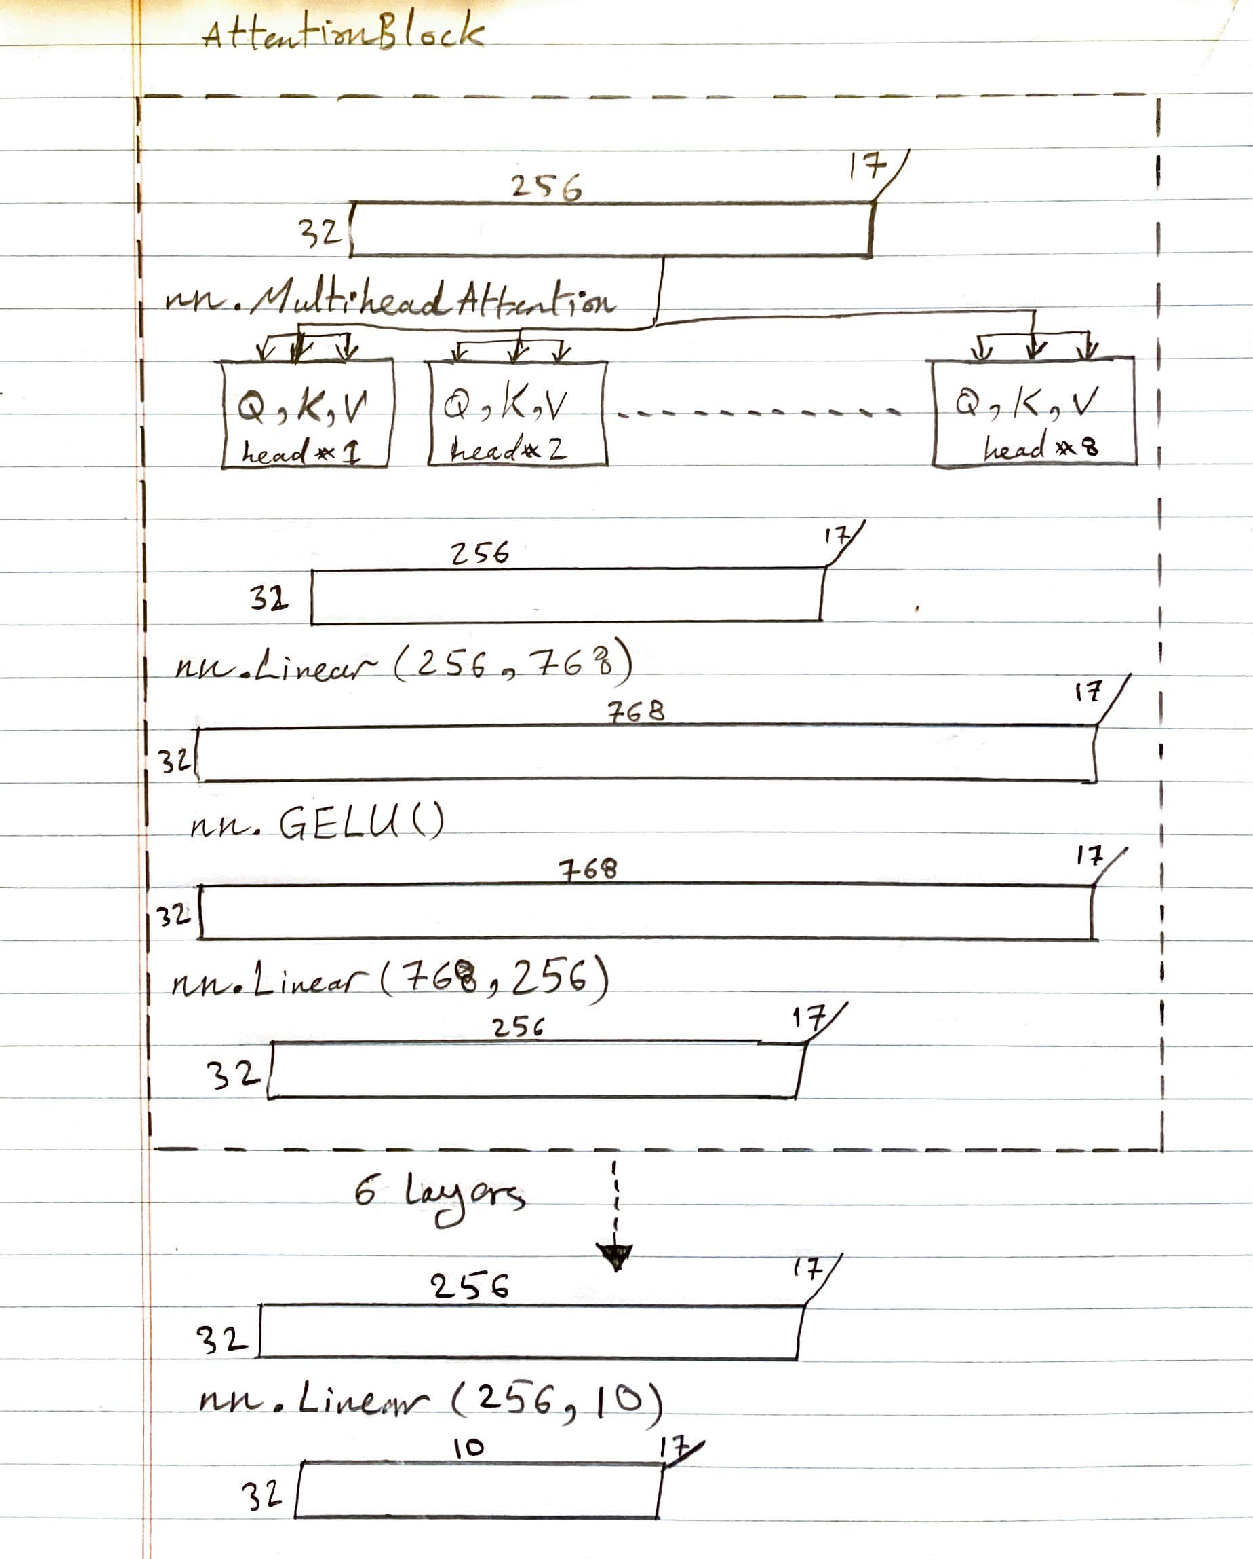

## ViT training

### Training loop

In [ ]:
# set an empty list to plot the loss later
loss_train_list = []
loss_val_list = []
loss_train_avg = 0
loss_val_avg = 0

start.record()

# Training loop
for epoch in range(20):
  for imgs, labels in tqdm_notebook(train_loader, desc='epoch '+str(epoch)):
    # Make sure gradient tracking is on, and do a pass over the data
    model_ViT.train(True)
    # Transfer to GPU
    imgs, labels = imgs.to(device), labels.to(device)
    # zero the parameter gradients
    model_ViT_optimizer.zero_grad()
    # Make predictions for this batch
    preds = model_ViT(imgs)
    # Compute the loss and its gradients
    loss = criterion(preds, labels)
    # append this loss to the list for later plotting
    loss_train_avg += loss
    # backpropagate the loss
    loss.backward()
    # adjust parameters based on the calculated gradients
    model_ViT_optimizer.step()


  # Set the model to evaluation mode, disabling dropout and using population
  model_ViT.eval()
  # Disable gradient computation and reduce memory consumption.
  with torch.inference_mode():
      for i, vdata in enumerate(val_loader):
          vinputs, vlabels = vdata
          vinputs, vlabels = vinputs.to(device), vlabels.to(device)
          voutputs = model_ViT(vinputs)
          vloss = criterion(voutputs, vlabels)
          loss_val_avg += vloss

  loss_train_avg = loss_train_avg/len(train_loader.dataset)
  loss_train_list.append(loss_train_avg.item())
  loss_val_avg = loss_val_avg/len(val_loader.dataset)
  loss_val_list.append(loss_val_avg.item())

  print(f'Epoch {epoch:03d} | train loss: {loss_train_avg:.4f} | validation loss: {loss_val_avg:.4f}')

end.record()
torch.cuda.synchronize()
time_ViT = start.elapsed_time(end)  # milliseconds

epoch 0:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 000 | train loss: 0.0535 | validation loss: 0.0465


epoch 1:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 001 | train loss: 0.0451 | validation loss: 0.0436


epoch 2:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 002 | train loss: 0.0421 | validation loss: 0.0416


epoch 3:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 003 | train loss: 0.0398 | validation loss: 0.0404


epoch 4:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 004 | train loss: 0.0379 | validation loss: 0.0390


epoch 5:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 005 | train loss: 0.0362 | validation loss: 0.0390


epoch 6:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 006 | train loss: 0.0349 | validation loss: 0.0381


epoch 7:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 007 | train loss: 0.0334 | validation loss: 0.0383


epoch 8:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 008 | train loss: 0.0321 | validation loss: 0.0383


epoch 9:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 009 | train loss: 0.0306 | validation loss: 0.0382


epoch 10:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 010 | train loss: 0.0292 | validation loss: 0.0375


epoch 11:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 011 | train loss: 0.0277 | validation loss: 0.0380


epoch 12:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 012 | train loss: 0.0263 | validation loss: 0.0385


epoch 13:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 013 | train loss: 0.0249 | validation loss: 0.0390


epoch 14:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 014 | train loss: 0.0233 | validation loss: 0.0384


epoch 15:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 015 | train loss: 0.0220 | validation loss: 0.0395


epoch 16:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 016 | train loss: 0.0205 | validation loss: 0.0395


epoch 17:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 017 | train loss: 0.0190 | validation loss: 0.0421


epoch 18:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 018 | train loss: 0.0178 | validation loss: 0.0417


epoch 19:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 019 | train loss: 0.0168 | validation loss: 0.0433


### Plot training and validation losses

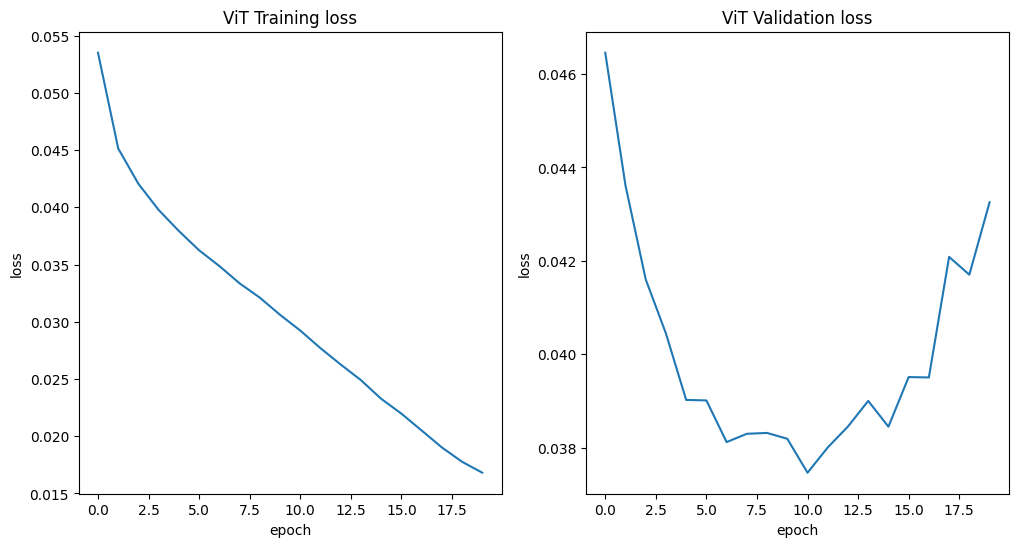

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.plot(loss_train_list)
ax1.set_title('ViT Training loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')

ax2.plot(loss_val_list)
ax2.set_title('ViT Validation loss')
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')
plt.show()

## ViT testing

In [ ]:
# Set the model to inference mode, disabling dropout.
model_ViT.eval()
# evaluate network
acc_total = 0
with torch.inference_mode():
  for imgs, labels in tqdm_notebook(test_loader):

    imgs, labels = imgs.to(device), labels.to(device)
    preds = model_ViT(imgs)
    pred_cls = preds.data.max(1)[1]
    acc_total += pred_cls.eq(labels.data).cpu().sum()

acc_ViT = acc_total.item()/len(test_loader.dataset)
print(f'Accuracy on test set = {acc_ViT*100:.2f}%')

  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on test set = 58.50%


## CNN vs ViT (accuracy and time)

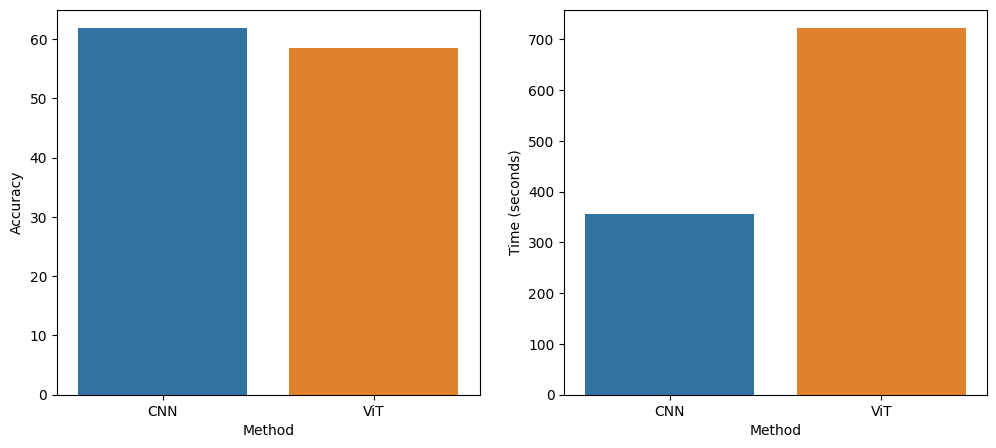

In [ ]:
data = {'Method': ['CNN', 'ViT'],
        'Accuracy': [acc_CNN*100, acc_ViT*100],
        'Time (seconds)': [time_CNN/1000, time_ViT/1000]}
df = pd.DataFrame(data)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.barplot(df,x='Method', y='Accuracy', ax=ax1)
sns.barplot(df,x='Method', y='Time (seconds)', ax=ax2)
plt.show()